# Power Electronics Challenge

This one is an open challenge, as even we (the research group) struggle with it. A description of the problem in the [EngiBench documentation](https://engibench.ethz.ch/problems/power_electronics/). The dataset can be found on [HuggingFace](https://huggingface.co/datasets/IDEALLab/power_electronics_v0).

If you manage to make it learn correctly for both DC Gain and Voltage Ripple, please do reach out to Florian Felten: ffelten@mavt.ethz.ch.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from engibench.problems.power_electronics.v0 import PowerElectronics


/Users/ffelte/Documents/ML4ME_Textbook/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ffelte/Documents/ML4ME_Textbook/venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/ffelte/Documents/ML4ME_Textbook/venv/lib/python3.12/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [2]:
# seeds
my_seed = 42

torch.manual_seed(my_seed)  # PyTorch
torch.backends.cudnn.deterministic = True
torch.cuda.benchmark = False
rng = np.random.default_rng(my_seed)  # NumPy

## Dataset loading and Processing


In [3]:
problem = PowerElectronics()
XY_train = problem.dataset["train"].with_format("numpy")
XY_test = problem.dataset["test"].with_format("numpy")

X_train = np.array(XY_train["initial_design"])
y_train = np.array([XY_train["Voltage_Ripple"], XY_train["DcGain"]]).T

X_test = np.array(XY_test["initial_design"])
y_test = np.array([XY_test["Voltage_Ripple"], XY_test["DcGain"]]).T

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (9676, 20)
y_train: (9676, 2)
X_test: (1383, 20)
y_test: (1383, 2)


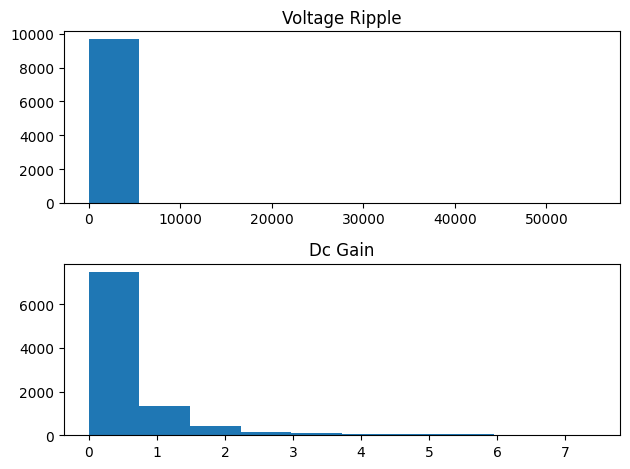

In [4]:
# make two subplots
fig, axs = plt.subplots(2, 1)
# plot histogram of voltage ripple
axs[0].hist(y_train[:, 0])
# plot histogram of dc gain
axs[1].hist(y_train[:, 1])
axs[0].set_title("Voltage Ripple")
axs[1].set_title("Dc Gain")
plt.tight_layout()
plt.show()

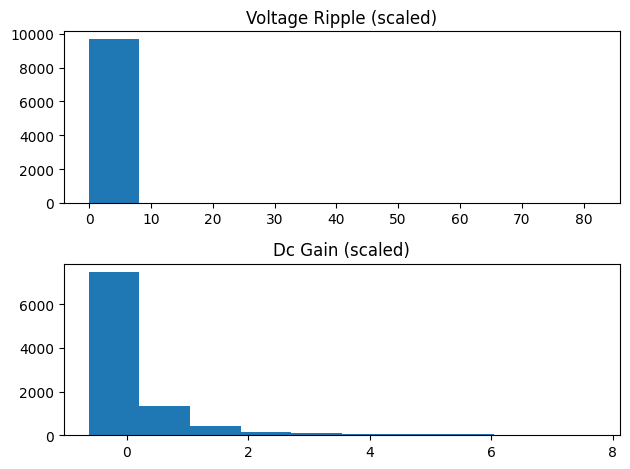

In [5]:
# Data preprocessing
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Normalizing our data, don't forget to unnormalize the predictions later!
X_train_scaled = torch.from_numpy(x_scaler.fit_transform(X_train)).float()
X_test_scaled = torch.from_numpy(x_scaler.transform(X_test)).float()
y_train_scaled = torch.from_numpy(y_scaler.fit_transform(y_train)).float()
y_test_scaled = torch.from_numpy(y_scaler.transform(y_test)).float()


# make two subplots
fig, axs = plt.subplots(2, 1)
# plot histogram of voltage ripple
axs[0].hist(y_train_scaled[:, 0])
# plot histogram of dc gain
axs[1].hist(y_train_scaled[:, 1])
axs[0].set_title("Voltage Ripple (scaled)")
axs[1].set_title("Dc Gain (scaled)")
plt.tight_layout()
plt.show()

## Model definition

In [6]:
# Model definition
class NetleF(nn.Module):
    """A very efficient neural network for the given task, probably the best for the job."""
    def __init__(self):
        super().__init__()
        layers = []
        layers.append(nn.Linear(20, 50)) # input layer
        for _ in range(5):
            layers.append(nn.ReLU()) # activation function
            layers.append(nn.Linear(50, 50)) # hidden layer
        layers.append(nn.ReLU()) # activation function
        layers.append(nn.Linear(50, 2)) # output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Training

Epoch   0 | Train loss: 1.0051 | Test loss: 0.5795
Epoch   5 | Train loss: 1.0006 | Test loss: 0.5736
Epoch  10 | Train loss: 0.9987 | Test loss: 0.5703
Epoch  15 | Train loss: 0.9977 | Test loss: 0.5679
Epoch  20 | Train loss: 0.9944 | Test loss: 0.5632
Epoch  25 | Train loss: 0.9869 | Test loss: 0.5529
Epoch  30 | Train loss: 0.9700 | Test loss: 0.5289
Epoch  35 | Train loss: 0.9363 | Test loss: 0.4812
Epoch  40 | Train loss: 0.8877 | Test loss: 0.4127
Epoch  45 | Train loss: 0.8451 | Test loss: 0.3564
Epoch  50 | Train loss: 0.8162 | Test loss: 0.3214
Epoch  55 | Train loss: 0.7867 | Test loss: 0.2918
Epoch  60 | Train loss: 0.7551 | Test loss: 0.2619
Epoch  65 | Train loss: 0.7368 | Test loss: 0.2406
Epoch  70 | Train loss: 0.7255 | Test loss: 0.2289
Epoch  75 | Train loss: 0.7127 | Test loss: 0.2199
Epoch  80 | Train loss: 0.7020 | Test loss: 0.2087
Epoch  85 | Train loss: 0.6893 | Test loss: 0.2006
Epoch  90 | Train loss: 0.6755 | Test loss: 0.1874
Epoch  95 | Train loss: 0.6594 

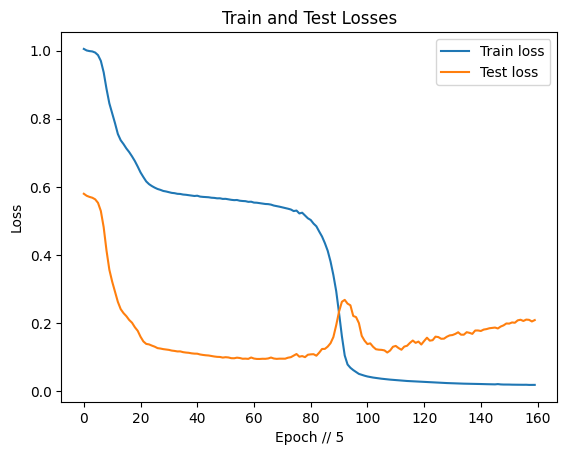

In [7]:
model = NetleF()

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = nn.MSELoss()

# Training loop
train_losses = []
test_losses = []
for epoch in range(800):
    y_pred_scaled = model(X_train_scaled).squeeze()
    loss = loss_fn(y_pred_scaled, y_train_scaled)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        with torch.no_grad(): # no gradients coming from the test set
            test_pred_scaled = model(X_test_scaled).squeeze()
            test_loss = loss_fn(test_pred_scaled, y_test_scaled)
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
        print(f"Epoch {epoch:3d} | Train loss: {loss.item():.4f} | Test loss: {test_loss.item():.4f}")

# plot train and test losses
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch // 5")
plt.ylabel("Loss")
plt.title("Train and Test Losses")
plt.legend()
plt.show()


## Visualization of Results

Voltage Ripple:
	 prediction:-0.6455363035202026
	 target:0.2652873
	 error:0.9108236035202026
Dc Gain:
	 prediction:0.6078761219978333
	 target:0.3844711
	 error:-0.22340502199783324
--------------------------------
Voltage Ripple:
	 prediction:-1.3593157529830933
	 target:1.50956
	 error:2.8688757529830933
Dc Gain:
	 prediction:0.036026377230882645
	 target:0.0256937
	 error:-0.010332677230882645
--------------------------------
Voltage Ripple:
	 prediction:5.714041709899902
	 target:75.22109
	 error:69.5070482901001
Dc Gain:
	 prediction:0.16609971225261688
	 target:0.02433093
	 error:-0.14176878225261688
--------------------------------


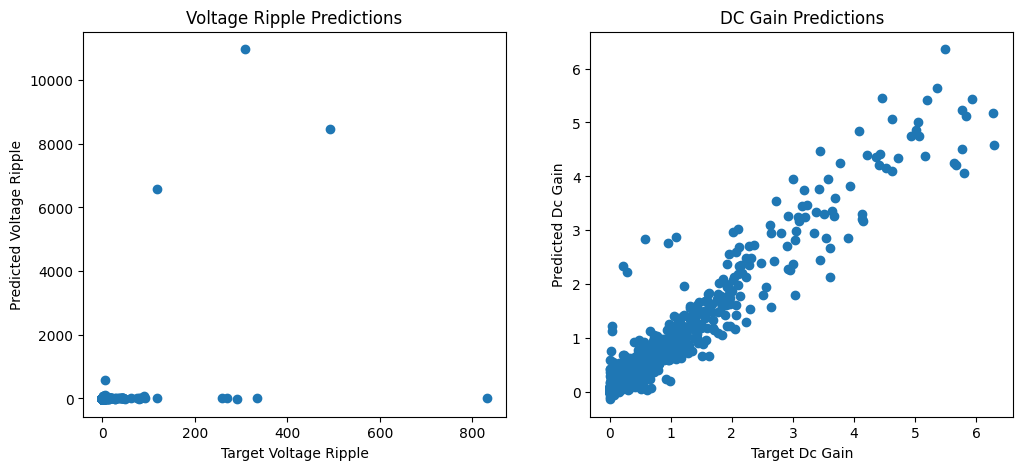

In [ ]:
# Several predictions
with torch.no_grad():
    test_pred_scaled = model(X_test_scaled)
    # unscale the predictions
    test_pred = torch.from_numpy(y_scaler.inverse_transform(test_pred_scaled.numpy())).float()

    # 5 random predictions
    random_indices = np.random.randint(0, len(test_pred), size=3)
    for i in random_indices:
        voltage_ripple_prediction = test_pred[i][0].item()
        voltage_ripple_target = y_test[i][0]
        voltage_ripple_error = voltage_ripple_target - voltage_ripple_prediction
        voltage_ripple_and_error = "Voltage Ripple:\n\t prediction:" + str(voltage_ripple_prediction) + "\n\t target:" + str(voltage_ripple_target) + "\n\t error:" + str(voltage_ripple_error)

        dc_gain_prediction = test_pred[i][1].item()
        dc_gain_target = y_test[i][1]
        dc_gain_error = dc_gain_target - dc_gain_prediction
        dc_gain_and_error = "Dc Gain:\n\t prediction:" + str(dc_gain_prediction) + "\n\t target:" + str(dc_gain_target) + "\n\t error:" + str(dc_gain_error)

        print(voltage_ripple_and_error)
        print(dc_gain_and_error)
        print("--------------------------------")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Voltage Ripple
axs[0].scatter(y_test[:,0], test_pred[:,0])
# axs[0].plot([y_test[:,0].min(), y_test[:,0].max()],
#            [y_test[:,0].min(), y_test[:,0].max()], "k--", alpha=0.5)
axs[0].set_xlabel("Target Voltage Ripple")
axs[0].set_ylabel("Predicted Voltage Ripple")
axs[0].set_title("Voltage Ripple Predictions")

# DC Gain
axs[1].scatter(y_test[:,1], test_pred[:,1])
# axs[1].plot([y_test[:,1].min(), y_test[:,1].max()],
#            [y_test[:,1].min(), y_test[:,1].max()], "k--", alpha=0.5)
axs[1].set_xlabel("Target Dc Gain")
axs[1].set_ylabel("Predicted Dc Gain")
axs[1].set_title("DC Gain Predictions")

plt.show()


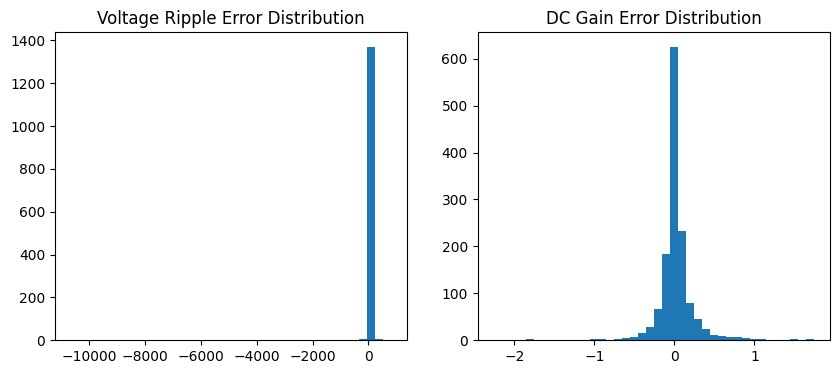

In [ ]:
test_pred_np = test_pred.numpy() if torch.is_tensor(test_pred) else test_pred

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(y_test[:,0] - test_pred_np[:,0], bins=40)
axs[1].hist(y_test[:,1] - test_pred_np[:,1], bins=40)
axs[0].set_title("Voltage Ripple Error Distribution")
axs[1].set_title("DC Gain Error Distribution")
plt.show()

